# 多层感知机的从零开始实现
:label:`sec_mlp_scratch`

我们已经在 :numref:`sec_mlp`中描述了多层感知机（MLP），
现在让我们尝试自己实现一个多层感知机。
为了与之前softmax回归（ :numref:`sec_softmax_scratch` ）
获得的结果进行比较，
我们将继续使用Fashion-MNIST图像分类数据集
（ :numref:`sec_fashion_mnist`）。


In [4]:
import torch
from torch import nn
# from d2l import torch as d2l

In [5]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## 初始化模型参数

回想一下，Fashion-MNIST中的每个图像由
$28 \times 28 = 784$个灰度像素值组成。
所有图像共分为10个类别。
忽略像素之间的空间结构，
我们可以将每个图像视为具有784个输入特征
和10个类的简单分类数据集。
首先，我们将[**实现一个具有单隐藏层的多层感知机，
它包含256个隐藏单元**]。
注意，我们可以将这两个变量都视为超参数。
通常，我们选择2的若干次幂作为层的宽度。
因为内存在硬件中的分配和寻址方式，这么做往往可以在计算上更高效。

我们用几个张量来表示我们的参数。
注意，对于每一层我们都要记录一个权重矩阵和一个偏置向量。
跟以前一样，我们要为损失关于这些参数的梯度分配内存。


In [6]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

## 激活函数

为了确保我们对模型的细节了如指掌，
我们将[**实现ReLU激活函数**]，
而不是直接调用内置的`relu`函数。


In [7]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

## 模型

因为我们忽略了空间结构，
所以我们使用`reshape`将每个二维图像转换为一个长度为`num_inputs`的向量。
只需几行代码就可以(**实现我们的模型**)。


In [8]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    return (H@W2 + b2)

## 损失函数

由于我们已经从零实现过softmax函数（ :numref:`sec_softmax_scratch`），
因此在这里我们直接使用高级API中的内置函数来计算softmax和交叉熵损失。
回想一下我们之前在 :numref:`subsec_softmax-implementation-revisited`中
对这些复杂问题的讨论。
我们鼓励感兴趣的读者查看损失函数的源代码，以加深对实现细节的了解。


In [9]:
loss = nn.CrossEntropyLoss(reduction='none')

## 训练

幸运的是，[**多层感知机的训练过程与softmax回归的训练过程完全相同**]。
可以直接调用`d2l`包的`train_ch3`函数（参见 :numref:`sec_softmax_scratch` ），
将迭代周期数设置为10，并将学习率设置为0.1.


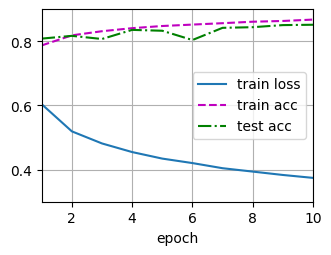

In [12]:
import matplotlib.pyplot as plt
from IPython import display

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        # d2l.use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: self.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def set_axes(self, axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置matplotlib的轴"""
        axes.set_xlabel(xlabel)
        axes.set_ylabel(ylabel)
        axes.set_xscale(xscale)
        axes.set_yscale(yscale)
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        if legend:
            axes.legend(legend)
        axes.grid()

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

为了对学习到的模型进行评估，我们将[**在一些测试数据上应用这个模型**]。


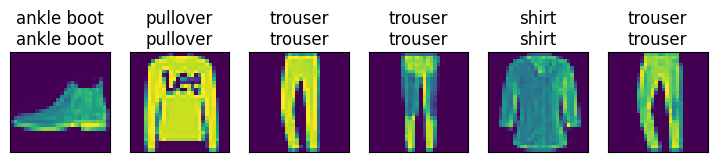

In [13]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## 小结

* 手动实现一个简单的多层感知机是很容易的。然而如果有大量的层，从零开始实现多层感知机会变得很麻烦（例如，要命名和记录模型的参数）。

## 练习

1. 在所有其他参数保持不变的情况下，更改超参数`num_hiddens`的值，并查看此超参数的变化对结果有何影响。确定此超参数的最佳值。
1. 尝试添加更多的隐藏层，并查看它对结果有何影响。
1. 改变学习速率会如何影响结果？保持模型架构和其他超参数（包括轮数）不变，学习率设置为多少会带来最好的结果？
1. 通过对所有超参数（学习率、轮数、隐藏层数、每层的隐藏单元数）进行联合优化，可以得到的最佳结果是什么？
1. 描述为什么涉及多个超参数更具挑战性。
1. 如果想要构建多个超参数的搜索方法，请想出一个聪明的策略。


[Discussions](https://discuss.d2l.ai/t/1804)
